## Import Libraries

In [1]:
!pip install tensorflow==2.15.0

In [2]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

2024-06-19 10:29:03.428940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 10:29:03.429069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 10:29:03.555639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data 

In [3]:
# Generate data paths with labels
data_dir = '/kaggle/input/capstone-dataset-children-autism/Autistic Children Emotion Merge'
filepaths = []
labels = []

# Path to folders
folds = os.listdir(data_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

df0 = pd.concat([Fseries, Lseries], axis= 1)
df0

,filepaths,labels
0,/kaggle/input/capstone-dataset-children-autism...,joy
1,/kaggle/input/capstone-dataset-children-autism...,joy
2,/kaggle/input/capstone-dataset-children-autism...,joy
3,/kaggle/input/capstone-dataset-children-autism...,joy
4,/kaggle/input/capstone-dataset-children-autism...,joy
...,...,...
826,/kaggle/input/capstone-dataset-children-autism...,anger
827,/kaggle/input/capstone-dataset-children-autism...,anger
828,/kaggle/input/capstone-dataset-children-autism...,anger
829,/kaggle/input/capstone-dataset-children-autism...,anger


In [4]:
df_counts = df0['labels'].value_counts().sort_index()
df_counts

labels
Natural      55
anger        69
fear         33
joy         392
sadness     214
surprise     68
Name: count, dtype: int64

## Data Augmented

In [5]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from PIL import Image
import Augmentor

label = df_counts.index

for i in label:
    input_dir = f"/kaggle/input/capstone-dataset-children-autism/Autistic Children Emotion Merge/{i}"
    output_dir = f"/kaggle/working/final_dataset/{i}"
    
    p = Augmentor.Pipeline(source_directory=input_dir, output_directory=output_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
#     p.flip_top_bottom(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
#     p.crop_random(probability=0.5, percentage_area=0.3)
    p.resize(probability=1.0, width=224, height=224)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
    
#     n = 500 - df_counts[i]
    n = 500
    
    try:
        p.sample(n)
    except Exception as e:
        print(f"Error processing {i}: {str(e)}")

Initialised with 55 image(s) found.
Output directory set to /kaggle/working/final_dataset/Natural.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B1221581000>: 100%|██████████| 500/500 [00:04<00:00, 114.28 Samples/s]


Initialised with 69 image(s) found.
Output directory set to /kaggle/working/final_dataset/anger.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B121FB98370>: 100%|██████████| 500/500 [00:05<00:00, 94.12 Samples/s] 


Initialised with 33 image(s) found.
Output directory set to /kaggle/working/final_dataset/fear.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B12ACEDEE00>: 100%|██████████| 500/500 [00:04<00:00, 101.69 Samples/s]


Initialised with 392 image(s) found.
Output directory set to /kaggle/working/final_dataset/joy.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B121FDEDB70>: 100%|██████████| 500/500 [00:05<00:00, 98.21 Samples/s] 


Initialised with 214 image(s) found.
Output directory set to /kaggle/working/final_dataset/sadness.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B121FA2C490>: 100%|██████████| 500/500 [00:04<00:00, 102.53 Samples/s]


Initialised with 68 image(s) found.
Output directory set to /kaggle/working/final_dataset/surprise.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7B12ACEDEBF0>: 100%|██████████| 500/500 [00:04<00:00, 124.84 Samples/s]


In [7]:
# Generate data paths with labels
aug_data_dir = '/kaggle/working/final_dataset'
labels = []

# Path to folders
folds = os.listdir(aug_data_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(aug_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

df1 = pd.concat([Fseries, Lseries], axis= 1)
df1.dropna(inplace = True)
df1

,filepaths,labels
0,/kaggle/input/capstone-dataset-children-autism...,surprise
1,/kaggle/input/capstone-dataset-children-autism...,surprise
2,/kaggle/input/capstone-dataset-children-autism...,surprise
3,/kaggle/input/capstone-dataset-children-autism...,surprise
4,/kaggle/input/capstone-dataset-children-autism...,surprise
...,...,...
2995,/kaggle/working/final_dataset/joy/joy_original...,anger
2996,/kaggle/working/final_dataset/joy/joy_original...,anger
2997,/kaggle/working/final_dataset/joy/joy_original...,anger
2998,/kaggle/working/final_dataset/joy/joy_original...,anger


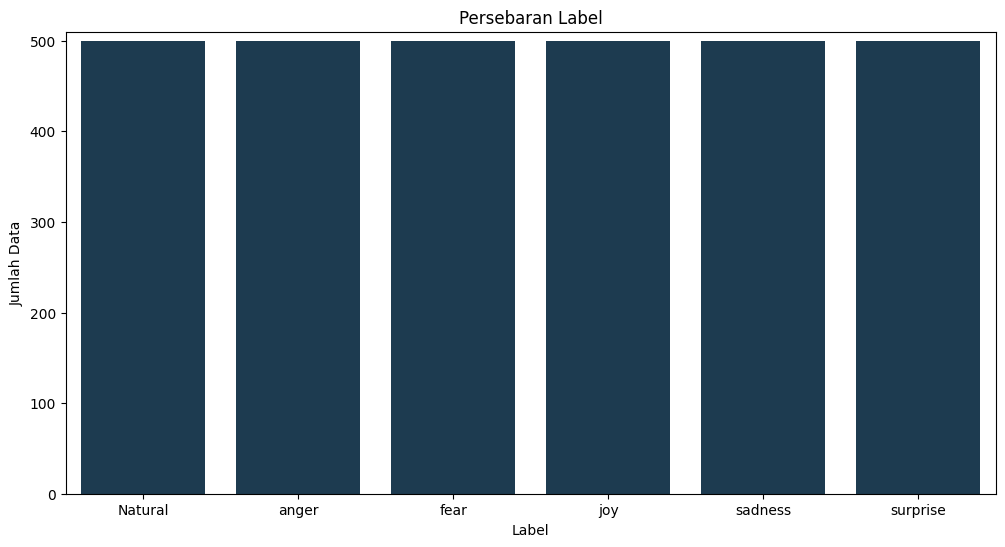

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot1(df, label_column='labels'):
    """
    Membuat barplot untuk memperlihatkan distribusi label pada satu DataFrame.

    Args:
    df (pd.DataFrame): DataFrame yang berisi data dengan kolom label.
    label_column (str): Nama kolom yang berisi label.
    """
    # Menghitung jumlah data per label
    label_counts = df[label_column].value_counts().sort_index()

    # Membuat DataFrame untuk plot
    counts_df = pd.DataFrame({'Label': label_counts.index, 'Jumlah Data': label_counts.values})
    counts_df['Label'] = counts_df['Label'].replace('dermatofibroma', 'dermato-\nfibroma')

    # Membuat barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Label', y='Jumlah Data', data=counts_df, palette=['#143d59'])

    # Menambahkan judul dan label sumbu
    plt.title('Persebaran Label')
    plt.xlabel('Label')
    plt.ylabel('Jumlah Data')

    # Mengatur batas sumbu y
    plt.ylim(0, counts_df['Jumlah Data'].max() + 10)

    # Menampilkan label dalam dua baris jika panjang
    labels = counts_df['Label'].unique()
    plt.xticks(range(len(labels)), [label.replace(" ", "\n") for label in labels])

    # Menampilkan plot
    plt.show()

plot1(df1)

## Processing

In [9]:
import pathlib

training_main = pathlib.Path('/kaggle/working/final_dataset')
image_count_train = len(list(training_main.glob('*/*.jpg')))
print(image_count_train)

2974


In [10]:
batch_size = 50
img_size = (224, 224)

train_gen = tf.keras.preprocessing.image_dataset_from_directory(
  training_main,
  shuffle = True,
  seed = 123,
  validation_split = 0.1,
  subset = 'training',
  image_size = img_size,
  batch_size = batch_size)

test_gen = tf.keras.preprocessing.image_dataset_from_directory(
  training_main,
  shuffle = False,
  seed = 123,
  validation_split = 0.1,
  subset = 'validation',
  image_size = img_size,
  batch_size = batch_size)

Found 3000 files belonging to 6 classes.
Using 2700 files for training.
Found 3000 files belonging to 6 classes.
Using 300 files for validation.


> ## Samples Of The Data


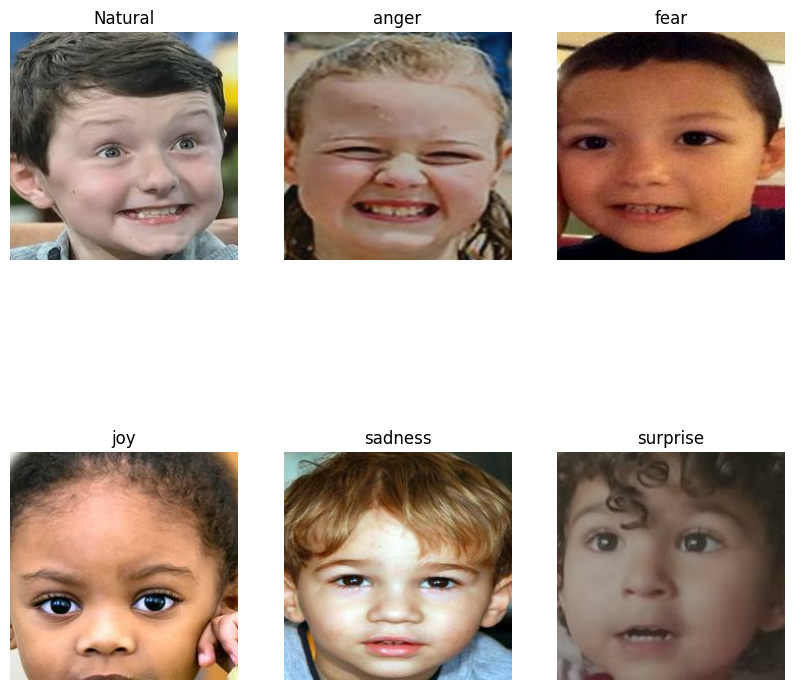

In [11]:
plt.figure(figsize=(10, 10))
for image, label in train_gen.take(1):
    for i in range (6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(df_counts.index[i])
        plt.axis("off")
     

# MobileNetV2

In [12]:
from tensorflow.keras.applications import MobileNetV2
mob_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3),include_top = False, weights='imagenet')
mob_model.trainable = False

# last_layer = mob_model.get_layer('block_12_expand')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

last_output = mob_model.output
print('last layer output shape: ', mob_model.output_shape)

9406464/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 1280)


In [13]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPooling2D

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

x = mob_model.output
# x = Dropout(0.2)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((1,1))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs = mob_model.input, outputs = x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy')>0.90) and (logs.get('val_accuracy')>0.90)):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
epochs = 50   

steps_per_epoch =  2700 // batch_size
validation_steps = 300 // batch_size

history = model.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps) #, callbacks = callback)

Epoch 1/50


I0000 00:00:1718793014.122550     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 [==============================] - 12s 71ms/step - loss: 1.8069 - accuracy: 0.1826 - val_loss: 1.8031 - val_accuracy: 0.0000e+00
Epoch 2/50
54/54 [==============================] - 3s 54ms/step - loss: 1.7610 - accuracy: 0.2163 - val_loss: 1.7647 - val_accuracy: 0.0167
Epoch 3/50
54/54 [==============================] - 3s 53ms/step - loss: 1.6704 - accuracy: 0.2967 - val_loss: 1.8943 - val_accuracy: 0.0000e+00
Epoch 4/50
54/54 [==============================] - 3s 53ms/step - loss: 1.5656 - accuracy: 0.3570 - val_loss: 1.6214 - val_accuracy: 0.1033
Epoch 5/50
54/54 [==============================] - 3s 53ms/step - loss: 1.4624 - accuracy: 0.3967 - val_loss: 1.7751 - val_accuracy: 0.1233
Epoch 6/50
54/54 [==============================] - 3s 54ms/step - loss: 1.3519 - accuracy: 0.4444 - val_loss: 1.4290 - val_accuracy: 0.4833
Epoch 7/50
54/54 [==============================] - 3s 53ms/step - loss: 1.2542 - accuracy: 0.4841 - val_loss: 1.5826 - val_accuracy: 0.4233
Epoch 8/50
54/5

In [16]:
# Save the model
model.save('Model_Emotion.h5')

> ## Model Performance

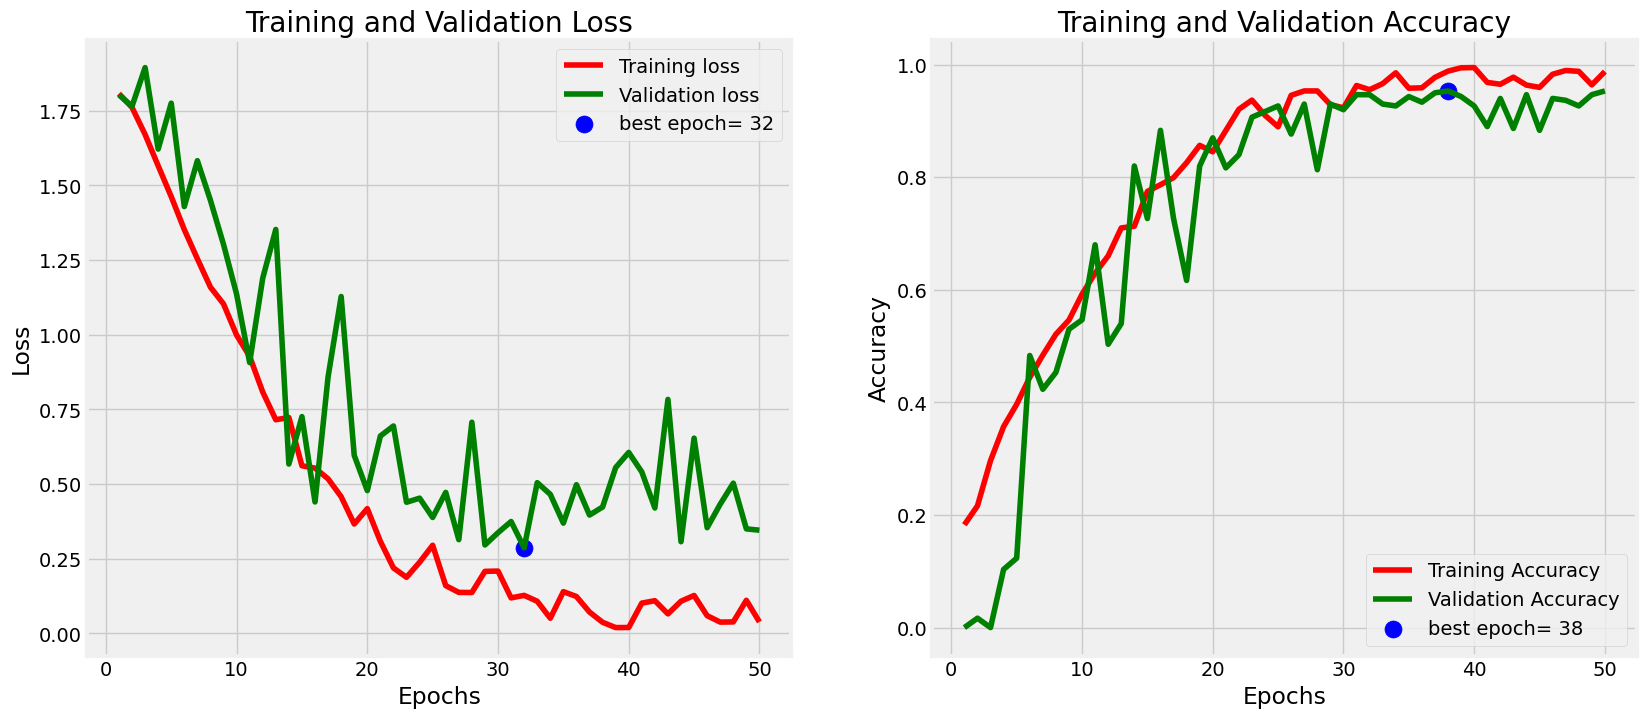

In [17]:
# Define needed variables
def f_history(history = history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

f_history(history)

## Convert Model

In [31]:
!pip install tensorflowjs --upgrade

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.3 MB/s eta 0:00:0000:01
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.15.0
    Uninstalling tensorflow-hub-0.15.0:
      Successfully uninstalled tensorflow-hub-0.15.0
  Attempting uninstall: tensorflowjs
    Found existing installation: tensorflowjs 4.16.0
    Uninstalling tensorflowjs-4.16.0:
      Successfully uninstalled tensorflowjs-4.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages tha

In [32]:
!tensorflowjs_converter --input_format keras /kaggle/working/Model_Emotion.h5 /kaggle/working/emotion_tfjs_model

2024-06-19 10:40:53.228671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 10:40:53.228730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 10:40:53.230105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
